<a href="https://colab.research.google.com/github/allfed/CropOpt/blob/standardize/notebooks/yield_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rerun these each time you open Colab

In [ ]:
!rm -rf allfed-integrated-model/
!git clone -b main https://github.com/allfed/allfed-integrated-model.git

In [ ]:
# This adds the Python files in our repo to our path so we can import
# them

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path) 

In [ ]:
!pip install PuLP
!pip install numpy
!pip install matplotlib

os.chdir('/content/allfed-integrated-model/notebooks/')


# Optimizer demo

The purpose of this file is to allow researchers to run the optimizer with differing assumptions. Please reach out to morgan@allfed.info if you have questions about this code.

This will recreate all graphs accessible in the recently submitted paper that were generated by the optimization model.

First, let's import the Optimizer, which runs through the code to optimize the minimum people fed of calories, fat, and protein. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np

/home/dmrivers/Code/allfed-integrated-model


Now, we run the no resilient food case, generating the total food production with resilient foods.

/home/dmrivers/.local/lib/python3.9/site-packages/pulp/apis/coin_api.py:89: UserWarning: Parameter fracGap is being depreciated for gapRel
  warnings.warn("Parameter fracGap is being depreciated for gapRel")



Estimated Kcals/capita/day, no resilient foods, no waste
1950.3390846153848

Estimated Kcals/capita/day, no resilient foods, minus waste & delayed halt of nonhuman consumption 
1601.2432153846155

saved figure 1ab


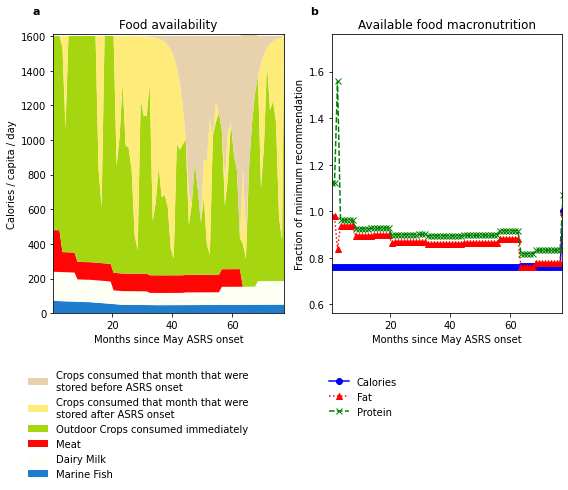

In [2]:
%run ../src/run_model_no_resilient_foods.py

Run the case with resilient foods. This will take a minute to converge on the diet.

/home/dmrivers/.local/lib/python3.9/site-packages/pulp/apis/coin_api.py:89: UserWarning: Parameter fracGap is being depreciated for gapRel
  warnings.warn("Parameter fracGap is being depreciated for gapRel")



no waste estimated people fed (kcals/capita/day)
3185.5664615384617

Food available after waste, feed ramp down and biofuel ramp down, with resilient foods (kcals per capita per day)
2681.4493461538464

Calculating 2100 calorie diet, excess feed to animals
saved figure 2abcd


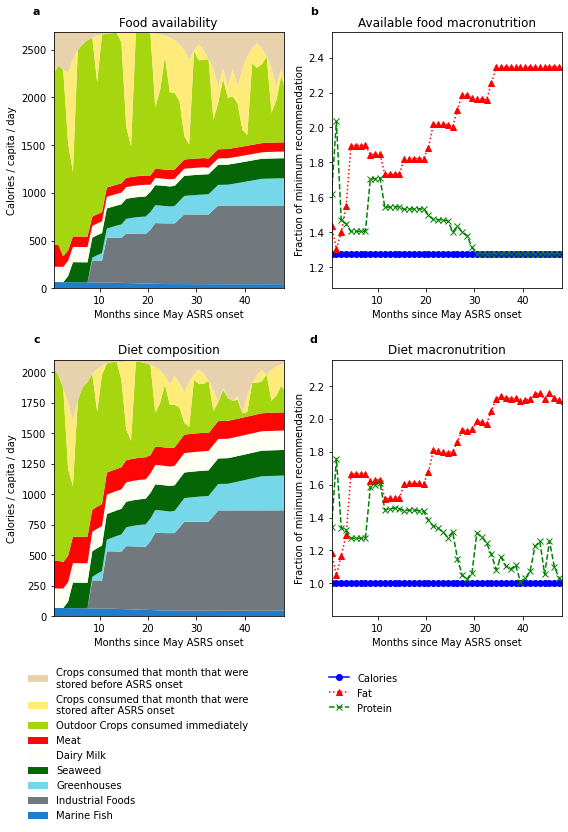

Diet computation complete


In [3]:
%run ../src/run_model.py

Run the baseline scenario in 2020

/home/dmrivers/.local/lib/python3.9/site-packages/pulp/apis/coin_api.py:89: UserWarning: Parameter fracGap is being depreciated for gapRel
  warnings.warn("Parameter fracGap is being depreciated for gapRel")



Maximum usable kcals/capita/day 2020, no waste, primary production
4402.576230769231

saved figure s1abcd


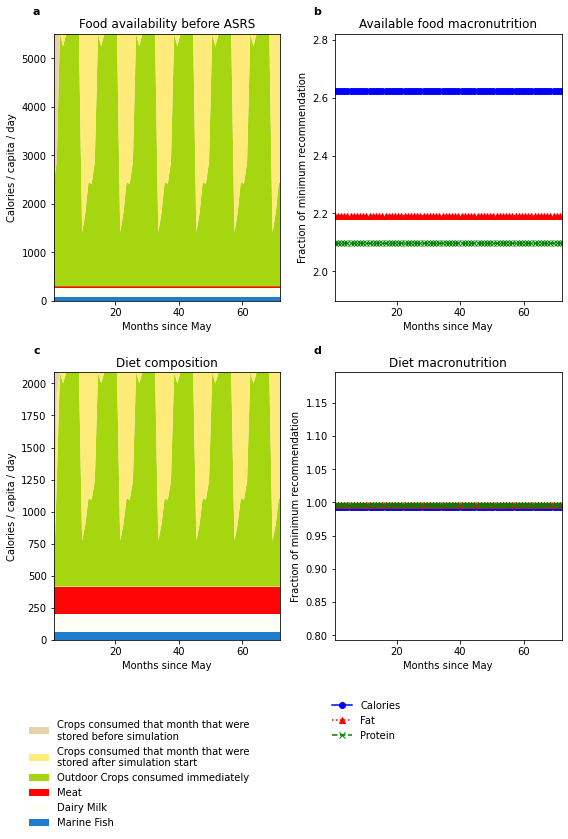

In [6]:
%run ../src/run_model_before_catastrophe.py

Run the Monte Carlo scenarios. We choose the "True" value for run_all_scenarios, which loads existing data from the monte carlo and plots it.

In [7]:
from src.monte_carlo import MonteCarlo

/home/dmrivers/.local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Computing input variables
Monte Carlo variables
saved figure s1


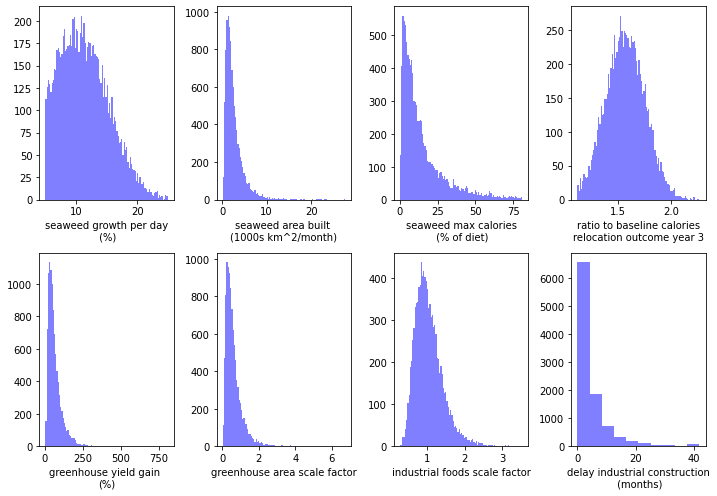

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


95% lower
2147.315555
95% upper
3491.7608115384605


/home/dmrivers/Code/allfed-integrated-model/src/plotter.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved figure 3ab


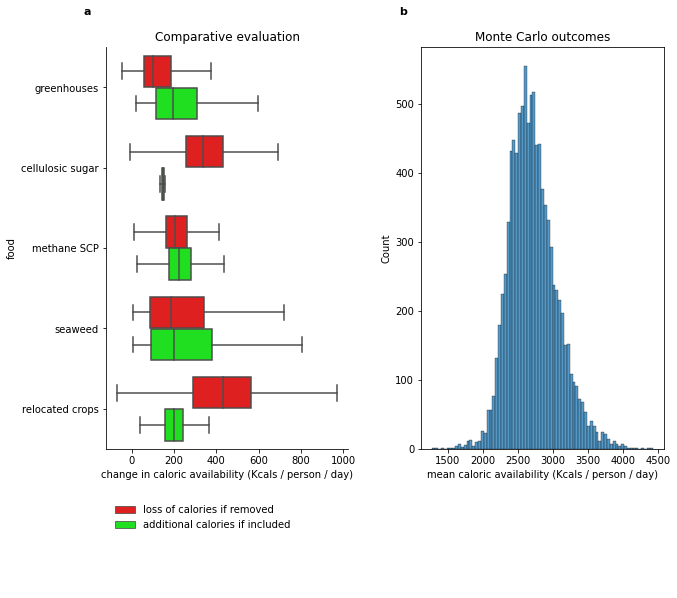

In [8]:
MonteCarlo.run_all_scenarios(10000, 1000, True, True)

Import analysis data saved in previous runs, and plot the result for primary production

saved figure s2abcd


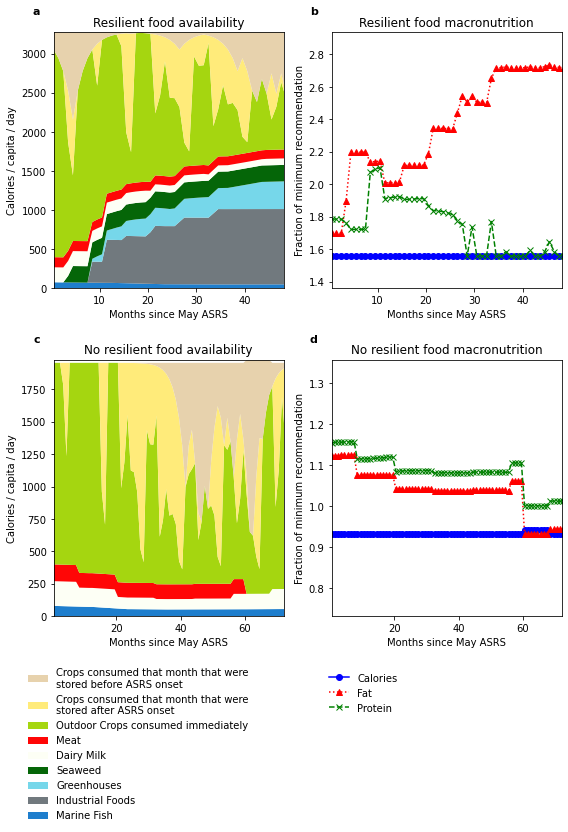

In [12]:
from src.plotter import Plotter
resilient_food_primary_production_analysis = np.load(
    '../data/resilient_food_primary_analysis.npy',
    allow_pickle=True).item()

no_resilient_food_primary_production_analysis = np.load(
    '../data/no_resilient_food_primary_analysis.npy',
    allow_pickle=True).item()

Plotter.plot_fig_s2abcd(
    resilient_food_primary_production_analysis,
    no_resilient_food_primary_production_analysis,
    48,
    72)
